# Exercise 2: Solar Compass from Polarization Images
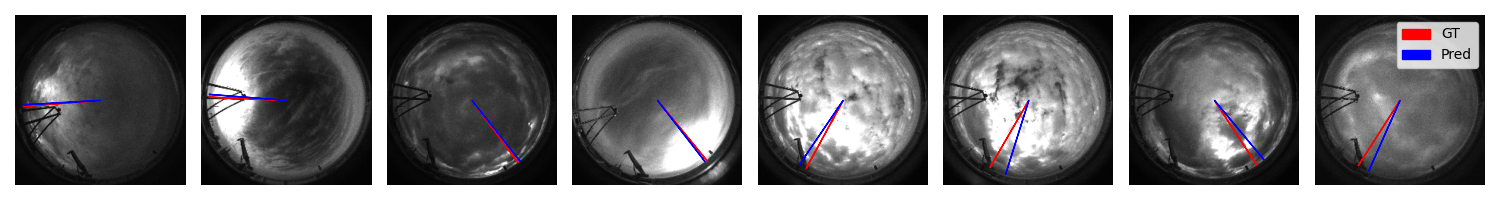
---
## Table of Contents
1. [Introduction](#introduction)
4. [Polarized Images](#polarized-images)
5. [Representation Selection](#representation-selection)
6. [Backbone](#backbone)
7. [Data Augmentation](#data-augmentation)
8. [CUDA (GPU Acceleration)](#cuda-gpu-acceleration)
9. [Training Loop](#training-loop)
    - [Tool: Tensorboard](#tool-tensorboard)


## Introduction
In this exercise, you will be tasked with building a neural network solution to estimate sun direction from images captured by a polarized camera. You will apply knowledge about data augmentation, convolutional networks into practice.

The goal is to train a model that predicts the sun’s direction based on polarized images. Accurate heading estimation is crucial for outdoor autonomous navigation, where robots typically rely on magnetometers. However, these sensors are vulnerable to electromagnetic interference. Inspired by insects’ ability to navigate using skylight polarization, this method presents a promising alternative.

To facilitate this, we have collected a dataset of polarized skylight images from the rooftop of our AE building. By using the exact timestamps and GPS coordinates of the images, we have deduced the sun’s direction as ground truth. Your task is to train a neural network using this ground truth data and develop a model robust enough to be deployed in real-world conditions.

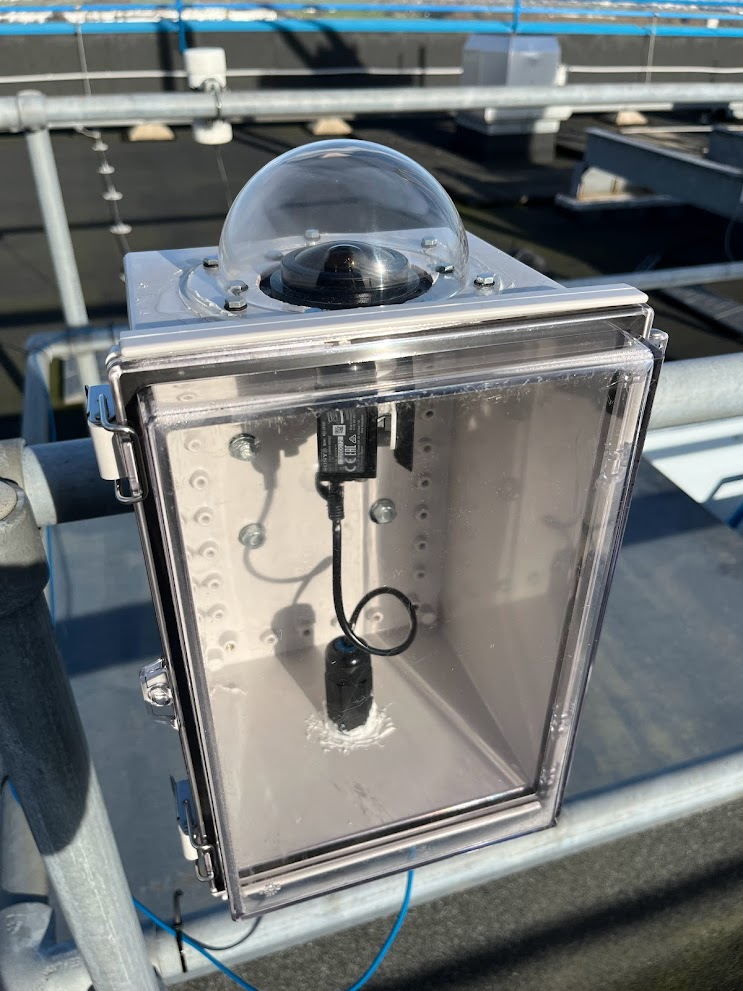

⚠️ We have provided the code for the dataset, dataloader, and loss function to save you time during the exercises. However, if you’re unfamiliar with how to implement these modules, we encourage you to review the code. You will need to implement them on your own for the competition, and they may also be tested in the final exam.

In [8]:
# Import external modules

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import os

In [11]:
# Load the dataset
import dataset
from dataset import PolImgDataset

dataset_path = "C:/Users/jaspe/AE4353-Y25/AE4353-Datasets-2025/polarization_dataset/polarization_dataset/"

base_dataset = PolImgDataset(
    dataset_path,
    h5=True,
    augment=True  # Apply augmentations if you want during training
)

<strong style="color:red;">TODO 0.0: Split the dataset into training and validation sets.`</strong>

We recommend using a 0.85 training to 0.15 validation split.

In [13]:
# Split the dataset into training and validation sets
from torch.utils.data import Subset

# ------------------------------------------------------------------------------
# 0.0 :Split the dataset into training and validation sets
# ------------------------------------------------------------------------------
torch.random.manual_seed(1)
total_len = len(base_dataset)

train_len = int(0.85 * total_len)
val_len = total_len - train_len

# Split dataset randomly
train_set, val_set = torch.utils.data.random_split(
    base_dataset, [train_len, val_len])

# ------------------------------------------------------------------------------
# END
# ------------------------------------------------------------------------------

# print train and validation set sizes if not ellipsis:

if train_set is not ... and val_set is not ...:
    print(f"Training set size: {len(train_set)}")
    print(f"Validation set size: {len(val_set)}")
else:
    print("Complete the dataset splitting code.")

Training set size: 2225
Validation set size: 393


## Polarized Images

Polarization cameras, like the Sony XCG-CP510 used in this dataset, capture not just the intensity and color of light but also detailed information about its polarization state. For each pixel in an image, these cameras typically produce a 4-dimensional vector, corresponding to the light intensity through polarizers oriented at four different angles: 0°, 45°, 90°, and 135°. These angles correspond to the following components:

- **0° Polarization ($I_0$)**: Intensity of light polarized horizontally.
- **45° Polarization ($I_{45}$)**: Intensity of light polarized at a 45° angle.
- **90° Polarization ($I_{90}$)**: Intensity of light polarized vertically.
- **135° Polarization ($I_{135}$)**: Intensity of light polarized at 135°.

<center>
<img src="assets/pol_angles.png" alt="image" width="250">
</center>

These four intensities allow for the calculation of the Stokes parameters: I, Q, and U, which describe the polarization state of the light.

- $I=\frac{1}{2} (I_0 + I_{45} + I_{90} + I_{135})$: The total intensity, representing the sum or average of the polarized intensities, providing the overall brightness of the light.
- $Q=I_0-I_{90}$: The difference in intensity between horizontally (0°) and vertically (90°) polarized light, indicating the degree of linear polarization along these axes.
- $U=I_{45}-I_{135}$: The difference in intensity between diagonally polarized light at 45° and 135°, complementing Q by describing linear polarization along diagonal axes.

In addition to IQU, two other important quantites can be derived: the Degree of Polarization (DOP) and the Angle of Polarization (AOP).

- $DOP = \frac{\sqrt{Q^2 + U^2}}{I}$ Degree of Polarization measures the fraction of light that is polarized compared to the total light intensity.

- $AOP = \frac{1}{2} \tan^{-1}\left(\frac{U}{Q}\right)$ Angle of Polarization describes the angle at which the light is polarized.

c:\Users\jaspe\AE4353-Y25\ex_2\dataset.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.angles[idx]),


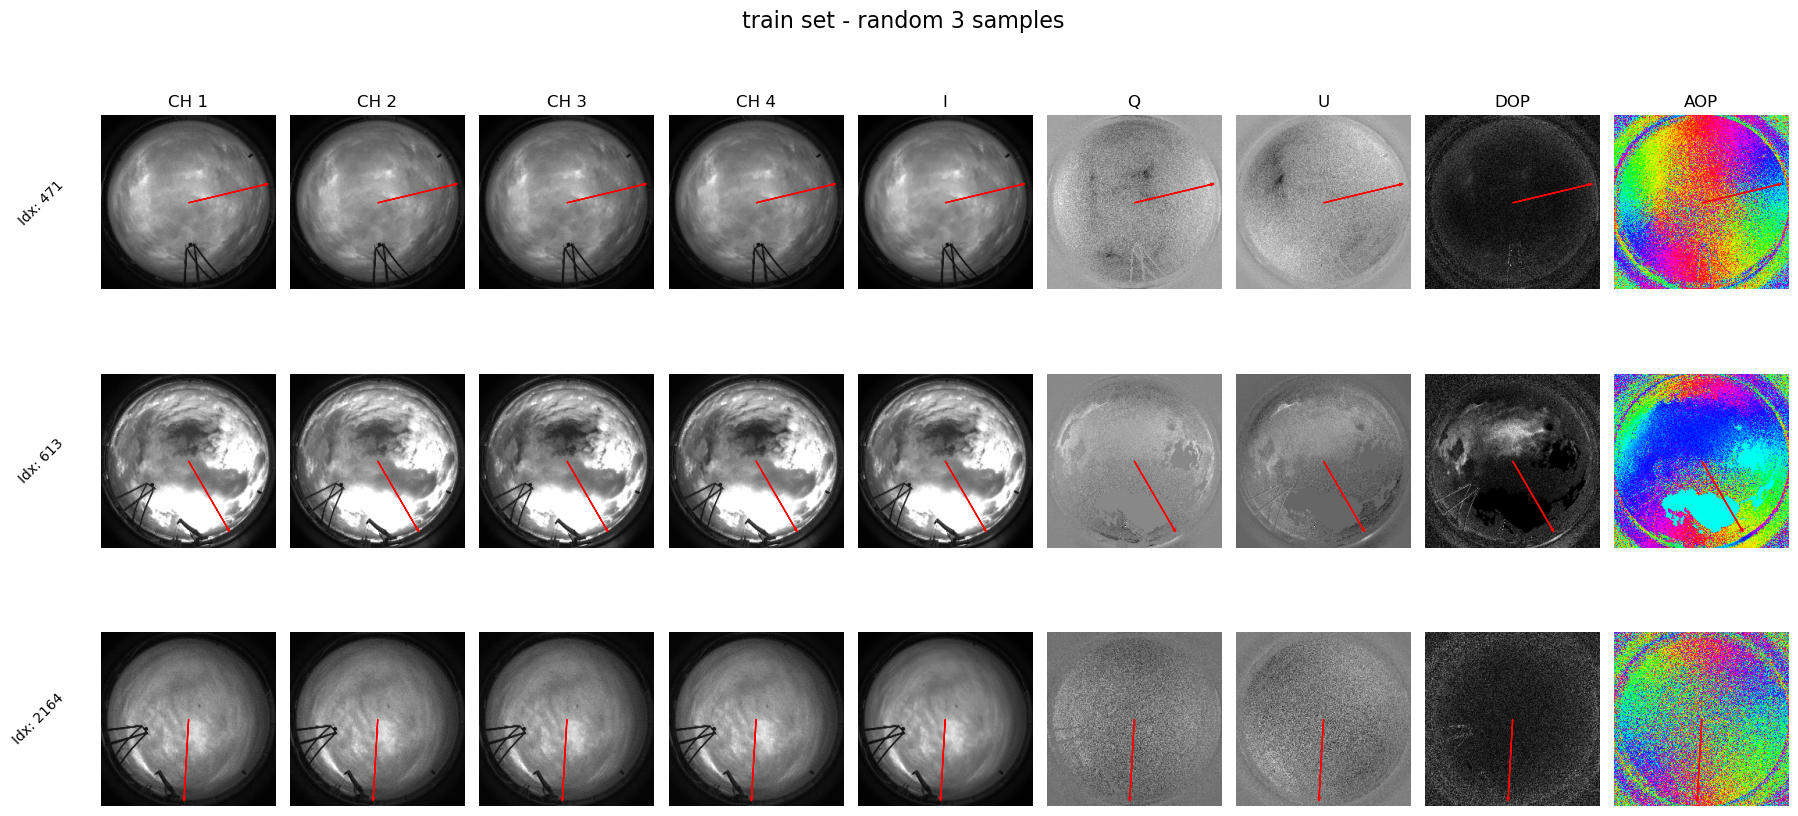

In [14]:
from additional.plots import plot_dataset_samples

plot_dataset_samples(train_set, dataset_name="train set", n_samples=3)

In [15]:
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

# Wrap subsets with DataLoader
train_loader = DataLoader(
    train_set,
    batch_size=32,   # you can tune this (depends on GPU memory)
    shuffle=True,    # shuffle only for training
    num_workers=0    # you can tune this (depends on CPU/GPU and system) - beware pickling error if you do!
)

val_loader = DataLoader(
    val_set,
    batch_size=32,
    shuffle=False,   # no shuffle for validation
    num_workers=0
)

## Representation Layer

Even though deep neural networks can be trained end-to-end, it’s still important to consider the representation layer: What input data provides the most effective representation. This becomes especially crucial when the amount of training data is limited.

In this exercise, we have several representations we could use:
- raw data (4 channels: CH1-CH4)
- IQU (3 channels: I,Q,U)
- DOP+AOP (2 channels: DOP and AOP)
- IQU+DOP+AOP (5 channels: I, Q, U, DOP and AOP)

<strong style="color:red;">TODO 1.1-1.3: Complete the implementation of the representation layers in the function `get_representation_layer`</strong>

For the output layer, we have a 2-dim unit vector pointing to the sun.

In the experiments, we are going to try out different representations to select the best one.

In [ ]:
# EXERCISE 1.1, 1.2, 1.3
# # We can use: raw data (4 channels), IQU, DOP+AOP, or IQU+DOP+AOP (5 channels)

def get_representation_layer(representation):
    assert representation in ["raw", "IQU", "DOP+AOP", "IQU+DOP+AOP"], "Invalid representation"

    #--------------------------------------------------------------
    # EXAMPLE 1.0: if representation is "raw", return identity layer
    #--------------------------------------------------------------
    if representation == "raw":
        channel_representation = 4
        representation_layer = nn.Identity()

    elif representation == "IQU":
        channel_representation = 3
    #--------------------------------------------------------------
    # TODO 1.1: write class for IQU representation
    #--------------------------------------------------------------
        class PolCh2IQU(nn.Module):
            def __init__(self):
                super().__init__()
                I_0
                I_45 = 
                I_90 = 
                I
            def forward(self, x):
                I = 1/2 * (I_0 + I_45 + I_90 + I_135)
                Q = I_0 - I_90
                U = I_45 - I_135
                return torch.stack([I, Q, U], axis=1)

        representation_layer = PolCh2IQU()
    #--------------------------------------------------------------
    # END OF TODO 1.1
    #--------------------------------------------------------------
    elif representation == "DOP+AOP":
        channel_representation = 2
    
    #--------------------------------------------------------------
    # TODO 1.2: write class for DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2DOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                pass
                return torch.stack((DOP, AOP), axis=1)

        representation_layer = PolCh2DOPAOP()
    
    #--------------------------------------------------------------
    # END OF TODO 1.2
    #--------------------------------------------------------------
    elif representation == "IQU+DOP+AOP":
        channel_representation = 5

    #--------------------------------------------------------------
    # TODO 1.3: write class for IQU+DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2IQUDOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                pass
                return torch.stack((I, Q, U, DOP, AOP), axis=1)

        representation_layer = PolCh2IQUDOPAOP()

    #--------------------------------------------------------------
    # END OF TODO 1.3
    #--------------------------------------------------------------
    return channel_representation, representation_layer
        

## Backbone
For the backbone of the network, we ask you to implement a vanilla CNN architecture. 


<strong style="color:red;">TODO 2.1-2.2: Complete the implementation of the vanilla CNN in `class VanillaCNN`</strong>

In [ ]:
# EXERCISE 2: Define the CNN architecture

import torch.nn.functional as F

class VanillaCNN(nn.Module):
    """
    A vanilla convolutional neural network model.
    with the following architecture:
    - Three convolutional layers each with 3x3 kernels, stride=1 w/ ReLU activation followed by a max pooling layer with 2x2 kernels.
    - The first layer has 16 output channels, the second has 32 output channels, and the third has 64 output channels.
    - Flatten the output of the last convolutional layer.
    - Two fully connected layers with ReLU activation with 128 hidden units and 64 hidden units.
    - One fully connected layer with linear activation as the output layer.

    Args:
        channel_in (int): Number of input channels.
        channel_out (int): Number of output channels.
        last_layer_bias (bool, optional): Whether to include bias in the last layer. Defaults to True.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        conv3 (nn.Conv2d): Third convolutional layer.
        fc1 (nn.LazyLinear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        fc3 (nn.Linear): Third fully connected layer.

    Methods:
        forward(x): Forward pass of the model.

    """

    def __init__(self, channel_in, channel_out, last_layer_bias=True):
        super().__init__()

        #--------------------------------------------------------------
        # TODO 2.1: Define the layers of the CNN as described above
        #--------------------------------------------------------------

        self.conv1 = ...
        pass

        self.fc1 = ...
        pass
        #-------------------------------------------------------------- 
        # END OF TODO 2.1
        #--------------------------------------------------------------

    #--------------------------------------------------------------
    # TODO 2.2: Implement the forward pass
    # --------------------------------------------------------------
        
    def forward(self, x):
        pass
    #--------------------------------------------------------------
    # END OF TODO 2.2
    #--------------------------------------------------------------
        return self.fc3(x)


## <span style="color:red;">[OPTIONAL]</span> Data Augmentation

Let’s visualize the distribution of sun direction in azimuth angles. As we can observe, the training and validation sets have different distributions, which poses a problem. The network could potentially overfit to the distribution of the training set and perform poorly on the validation set. This could result in a model that outputs only angles greater than 180 degrees, while failing to predict angles below that threshold for example.

To address this issue, we can augment the training data using horizontal and vertical flipping. When we apply these transformations, we also adjust the labels accordingly, ensuring the azimuth angles are flipped both horizontally and vertically. This process allows us to cover the full 360-degree range of angles, improving the network’s generalizability. As a result, the network is forced to learn a solution that maps to all angles, encompassing the range found in the validation set.


<strong style="color:red;">TODO X: Complete the data augmentation code in `ex_2/dataset.py: PolImgDataset.__getitem__`</strong>

Tip: You may first skip this part to work on other parts of the pipeline. Once your training pipeline works, you may come back here to implement augmentation to further improve performance.

Note: It is **very important** that you implement the augmentation in accordance with the correct physical laws. Performing augmentations incorrectly will lead to deterioration of performance and even unstable training. Hint: what happens to the four polarization channels when the sun is flipped in nature?

In [ ]:
from additional.plots import plot_raw_vs_augmented_angles

# store both the raw and augmented dataset for comparison
dataset_raw = PolImgDataset(
    dataset_path,
    h5=True,
    augment=False  # No augmentations for raw dataset
)
dataset_aug = PolImgDataset(
    dataset_path,
    h5=True,
    augment=True  # Apply augmentations for augmented dataset
)

plot_raw_vs_augmented_angles(dataset_raw, dataset_aug, train_indices, val_indices)

## Training Loop
Our main training loop is defined below. We will define ***1 class***:
1. `class PolarSunNet` : this is given. It is our `nn.Module` call, and represents the wrapper for our model. We set it up this way, so that if you feel like testing other backbones (<strong style="color:red;">optional task for those who want to experiment</strong>) they can simply add the code for an alternate backbone and replace the backbone variable in `PolarSunNet`.

And 2 Functions:

1. `evaluate` : used to evaluate the performance of the model on a given dataloader.
2. `train_epoch` : Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion. 

To thoroughly conduct the experiments, <strong style="color:red;">you should try out all the representation methods. For each representation, you should tune the batch size and learning rate.</strong> 

`Note`: the optimal learning rate will vary from case to case.

The optimal combination should yield a validation error less than 15 degrees (mean) and 5 degress (median) after trained to convergence.

> Tip: First try to get all the TODOs implemented. Verify the implementation by making sure the training pipeline runs without error and the training loss and validation error is going down after every epoch. Start with a small number of epochs (e.g. 3) on your laptop or codespaces. Once you are confident the code works, move to a GPU environment for full-scale experiments and hyperparameter tuning.

In [ ]:
def get_readout_layer():
    """
    Returns the output features and the function to compute angles
    from a 2D vector representation.
    """
    out_features = 2  # 2-dimensional vector output

    def get_angle(x):
        # x is a 2D vector; compute angle in degrees in [0, 360)
        return torch.remainder(torch.rad2deg(torch.atan2(x[:, 1], x[:, 0])), 360)

    return out_features, get_angle


class PolarSunNet(nn.Module):
    """
    Neural network to estimate sun angles from input images/tensors
    using a 2D vector representation.
    """
    def __init__(self, backbone, representation):
        super().__init__()

        # representation: tuple (num_input_channels, representation_layer)
        channel_representation, self.representation_layer = representation

        # always use vector readout
        out_features, self.get_angle = get_readout_layer()

        # initialize backbone with correct input channels and output features
        self.backbone = backbone(channel_representation, out_features)

    def forward(self, x):
        # transform input with the representation layer
        x = self.representation_layer(x)

        # pass through the backbone
        out = self.backbone(x)
        return out

    def estimate_angle(self, x):
        # compute angle using the vector readout
        return self.get_angle(self.forward(x))

<strong style="color:red;">TODO 3.1: Write the evaluate function:</strong> 


In [ ]:
from tqdm.notebook import tqdm


def evaluate(dataloader, model, criterion):
    """
    Evaluate the performance of a model on a given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        model (torch.nn.Module): The model to be evaluated.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        tuple: A tuple containing the average loss, evaluation metric (mean, median, and all values), and predictions.

    """
    # --------------------------------------------------------------
    # TODO 3.1: Implement the evaluation function
    # --------------------------------------------------------------

    pass

    # --------------------------------------------------------------
    # END OF TODO 3.1
    # --------------------------------------------------------------

    return sum(loss) / len(loss), (metric.mean(), metric.median(), metric), pred

<strong style="color:red;">TODO 4.1: Implement the train_epoch function:</strong> 


In [ ]:
from tqdm.notebook import tqdm


def train_epoch(train_loader, val_loader, model, optimizer, criterion):
    """
    Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion.
    Args:
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
    Returns:
        tuple: A tuple containing the training loss, training performance, validation performance, and validation predictions.
    """
    # --------------------------------------------------------------
    # TODO 4.1: Implement the training loop for one epoch
    # --------------------------------------------------------------

    pass

    # --------------------------------------------------------------
    # END OF TODO 4.1
    # --------------------------------------------------------------

    return train_loss, train_performance, val_performance, val_pred

# Assembling the model

We now have all the core components defined, and are ready to define themodel, and key configuration details. In the cells below, complete the following:

<strong style="color:red;">TODO 5.1-5.2: Complete the model definition configuration variables listed below.</strong> 


In [ ]:
# ASSEMBLE THE MODEL AND CONFIGURATION
# --------------------------------------------------------------
# TODO 5.1: Assemble the model using your implemented components
# --------------------------------------------------------------

model = ...
# --------------------------------------------------------------
# END OF TODO 5.1
# --------------------------------------------------------------

# --------------------------------------------------------------
# TODO 5.2: Write out your configuration variables
# --------------------------------------------------------------

epochs = ...
device = ...
optimizer = ...
criterion = ...
# --------------------------------------------------------------
# END OF TODO 5.2
# --------------------------------------------------------------

if representation is not ... and readout is not ... and model is not ...:
    print(representation)
    print(readout)
    print(model)
else:
    print("Complete the model assembly code.")

if epochs is not ... and device is not ... and optimizer is not ... and criterion is not ...:
    print(f"Training for {epochs} epochs on device: {device}")
    print(f"Using optimizer: {optimizer}")
    print(f"Using criterion: {criterion}")
else:
    print("Complete the configuration code.")
    
val_angles = base_dataset.angles[val_indices]


Now that we have defined the training loop, model and configuration variables we are ready to run the training loop:

<strong style="color:red;">TODO 6.1: Complete the training loop and run your model:</strong>


In [ ]:
from tqdm import tqdm
from warnings import filterwarnings
import matplotlib.pyplot as plt

from additional.plots import plot_angle_histogram


filterwarnings("ignore", category=UserWarning)

plt.ion()          # turn on interactive mode (important!)
fig = plt.figure() # create a persistent figure

# --------------------------------------------------------------
# TODO 6.1: Write the training loop
# --------------------------------------------------------------
pass
# --------------------------------------------------------------
# END OF TODO 6.1
# --------------------------------------------------------------

    # Print metrics
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"  Train Loss:       {train_loss:.4f}")
    print(f"  Train Error Mean: {train_error_mean:.4f}")
    print(f"  Train Error Median: {train_error_median:.4f}")
    print(f"  Val Error Mean:   {val_err_mean:.4f}")
    print(f"  Val Error Median: {val_err_median:.4f}")

    # Overwrite histogram in the same window
    plt.clf()
    plot_angle_histogram(val_pred, val_angles)
    plt.draw()
    plt.pause(0.1)  # allows GUI loop to update

plt.ioff()  # turn off interactive mode
plt.show()  # keep final plot open

In [ ]:
train_loss, train_performance, _ = evaluate(train_loader, model, criterion)

### Result Visualization:

Several different methods can be used to visualise the performance of your network. AS you can see we have provided a function `plot_angle_histogram` which plots the predicted angle as well as ground truth angles for the full training set. Although this is a nice graph, and it does show interesting information, it is quite tricky to deduct how well your network performs.

Therefore in the next two cells we provide the code to generate a histogram showing the error distribution for both the training and validation set. If your network performs well, you should expect a large spike on the left hand side of the plot, showing a that your network predictions have a low angle error at a very high frequency.

The second plot then shows the predicted angle and ground truth angle over a gray scaled sky polarization image.

> As a thought exercise, consider why your network performs the way it does? Which representation did you use? Does the behaviour you see align with what you would expect? If so, why or why not? Specifically, does the RGB case perform better or worse than you would expect? Why is that?

In [ ]:
from additional.plots import plot_error_histograms

plot_error_histograms(train_error_tensor, val_error_tensor)

In [ ]:
from additional.plots import plot_predictions_scaled

plot_predictions_scaled(val_set, model, device, n_samples=5)

# Solutions:

As before we post some ***suggested*** approaches you can take to solve the problems above. Please note, none of these are the most optimal solutions. They are examples of what you can do to solve the problem without over complicating it.

> As a challenge, feel free to try and optimize these solutions. 

In [ ]:
# Split the dataset into training and validation sets
from torch.utils.data import Subset

# ------------------------------------------------------------------------------
# 0.0 :Split the dataset into training and validation sets
# ------------------------------------------------------------------------------

total_len = len(base_dataset)

train_len = int(0.85 * total_len)
val_len = total_len - train_len

train_indices = list(range(0, train_len))
val_indices = list(range(train_len, total_len))

train_set = Subset(base_dataset, train_indices)
val_set = Subset(base_dataset, list(range(train_len, total_len)))

# ------------------------------------------------------------------------------
# END
# ------------------------------------------------------------------------------

In [ ]:
# EXERCISE 1.1, 1.2, 1.3
# # We can use: raw data (4 channels), IQU, DOP+AOP, or IQU+DOP+AOP (5 channels)

def get_representation_layer(representation):
    assert representation in ["raw", "IQU", "DOP+AOP", "IQU+DOP+AOP"], "Invalid representation"

    #--------------------------------------------------------------
    # EXAMPLE 1.0: if representation is "raw", return identity layer
    #--------------------------------------------------------------
    if representation == "raw":
        channel_representation = 4
        representation_layer = nn.Identity()

    elif representation == "IQU":
        channel_representation = 3
    #--------------------------------------------------------------
    # TODO 1.1: write class for IQU representation
    #--------------------------------------------------------------
        class PolCh2IQU(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                return torch.stack([I, Q, U], axis=1)

        representation_layer = PolCh2IQU()
    #--------------------------------------------------------------
    # END OF TODO 1.1
    #--------------------------------------------------------------
    elif representation == "DOP+AOP":
        channel_representation = 2
    
    #--------------------------------------------------------------
    # TODO 1.2: write class for DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2DOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                DOP = torch.sqrt(Q**2 + U**2) / I
                AOP = 0.5 * torch.arctan2(U, Q)
                return torch.stack((DOP, AOP), axis=1)

        representation_layer = PolCh2DOPAOP()
    
    #--------------------------------------------------------------
    # END OF TODO 1.2
    #--------------------------------------------------------------
    elif representation == "IQU+DOP+AOP":
        channel_representation = 5

    #--------------------------------------------------------------
    # TODO 1.3: write class for IQU+DOP+AOP representation
    #--------------------------------------------------------------
        class PolCh2IQUDOPAOP(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                I = 0.5 * x.sum(axis=1)
                Q = x[:, 0] - x[:, 2]
                U = x[:, 1] - x[:, 3]
                DOP = torch.sqrt(Q**2 + U**2) / I
                AOP = 0.5 * torch.arctan2(U, Q)
                return torch.stack((I, Q, U, DOP, AOP), axis=1)

        representation_layer = PolCh2IQUDOPAOP()

    #--------------------------------------------------------------
    # END OF TODO 1.3
    #--------------------------------------------------------------
    return channel_representation, representation_layer
        

In [ ]:
# EXERCISE 2: Define the CNN architecture

import torch.nn.functional as F

class VanillaCNN(nn.Module):
    """
    A vanilla convolutional neural network model.
    with the following architecture:
    - Three convolutional layers each with 3x3 kernels, stride=1 w/ ReLU activation followed by a max pooling layer with 2x2 kernels.
    - The first layer has 16 output channels, the second has 32 output channels, and the third has 64 output channels.
    - Flatten the output of the last convolutional layer.
    - Two fully connected layers with ReLU activation with 128 hidden units and 64 hidden units.
    - One fully connected layer with linear activation as the output layer.

    Args:
        channel_in (int): Number of input channels.
        channel_out (int): Number of output channels.
        last_layer_bias (bool, optional): Whether to include bias in the last layer. Defaults to True.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        conv3 (nn.Conv2d): Third convolutional layer.
        fc1 (nn.LazyLinear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.
        fc3 (nn.Linear): Third fully connected layer.

    Methods:
        forward(x): Forward pass of the model.

    """

    def __init__(self, channel_in, channel_out, last_layer_bias=True):
        super().__init__()

        #--------------------------------------------------------------
        # TODO 2.1: Define the layers of the CNN as described above
        #--------------------------------------------------------------

        self.conv1 = nn.Conv2d(channel_in, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.LazyLinear(out_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, channel_out, bias=last_layer_bias)
        #-------------------------------------------------------------- 
        # END OF TODO 2.1
        #--------------------------------------------------------------

    #--------------------------------------------------------------
    # TODO 2.2: Implement the forward pass
    # --------------------------------------------------------------
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
    
    #--------------------------------------------------------------
    # END OF TODO 2.2
    #--------------------------------------------------------------
        return self.fc3(x)

In [ ]:
from tqdm.notebook import tqdm


def evaluate(dataloader, model, criterion):
    """
    Evaluate the performance of a model on a given dataloader.

    Args:
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        model (torch.nn.Module): The model to be evaluated.
        criterion (torch.nn.Module): The loss function used for evaluation.

    Returns:
        tuple: A tuple containing the average loss, evaluation metric (mean, median, and all values), and predictions.

    """
    # --------------------------------------------------------------
    # TODO 3.1: Implement the evaluation function
    # --------------------------------------------------------------

    model.eval()

    loss = []
    pred = []
    metric = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            inputs, vector_gt, angle_gt = batch
            inputs = inputs.to(device)
            angle_gt = angle_gt.to(device)
            vector_gt = vector_gt.to(device)
            outputs = model(inputs)
            loss.append(criterion(outputs, vector_gt).item())
            angle_pred = model.get_angle(outputs)
            pred.extend(angle_pred.tolist())
            angle_error = torch.abs(angle_pred - angle_gt)
            angle_error = torch.min(angle_error, 360 - angle_error)
            metric.extend(angle_error.tolist())

    metric = torch.tensor(metric)
    pred = torch.tensor(pred)

    # --------------------------------------------------------------
    # END OF TODO 3.1
    # --------------------------------------------------------------

    return sum(loss) / len(loss), (metric.mean(), metric.median(), metric), pred

In [ ]:
from tqdm.notebook import tqdm


def train_epoch(train_loader, val_loader, model, optimizer, criterion):
    """
    Trains the model for one epoch using the provided data loaders, model, optimizer, and criterion.
    Args:
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        model (torch.nn.Module): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function used for training.
    Returns:
        tuple: A tuple containing the training loss, training performance, validation performance, and validation predictions.
    """
    # --------------------------------------------------------------
    # TODO 4.1: Implement the training loop for one epoch
    # --------------------------------------------------------------

    model.train()

    for x, y_gt_vector, y_gt_angles in tqdm(train_loader, desc="Training", leave=False):

        x = x.to(device)
        y_gt_angles = y_gt_angles.to(device)
        y_gt_vector = y_gt_vector.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y_gt_vector)
        loss.backward()

        optimizer.step()

    train_loss, train_performance, _ = evaluate(train_loader, model, criterion)
    _, val_performance, val_pred = evaluate(val_loader, model, criterion)

    # --------------------------------------------------------------
    # END OF TODO 3.1
    # --------------------------------------------------------------

    return train_loss, train_performance, val_performance, val_pred

In [ ]:
# ASSEMBLE THE MODEL AND CONFIGURATION
# --------------------------------------------------------------
# TODO 5.1: Assemble the model using your implemented components
# --------------------------------------------------------------

representation = get_representation_layer("IQU")    # or "raw", "DOP+AOP", "IQU+DOP+AOP"

# build the full model
model = PolarSunNet(
    backbone=VanillaCNN,
    representation=representation
)
# --------------------------------------------------------------
# END OF TODO 5.1
# --------------------------------------------------------------

# --------------------------------------------------------------
# TODO 5.2: Write out your configuration variables
# --------------------------------------------------------------

epochs = 50 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
val_angles = base_dataset.angles[val_indices]

# --------------------------------------------------------------
# END OF TODO 5.2
# --------------------------------------------------------------

In [ ]:
from tqdm import tqdm
from warnings import filterwarnings
import matplotlib.pyplot as plt

from additional.plots import plot_angle_histogram


filterwarnings("ignore", category=UserWarning)

plt.ion()          # turn on interactive mode (important!)
fig = plt.figure() # create a persistent figure

# --------------------------------------------------------------
# TODO 6.1: Write the training loop
# --------------------------------------------------------------

for epoch in tqdm(range(epochs), desc="Epochs"):
    (
        train_loss,
        (train_error_mean, train_error_median, train_error_tensor),
        (val_err_mean, val_err_median, val_error_tensor),
        val_pred,
    ) = train_epoch(train_loader, val_loader, model, optimizer, criterion)

# --------------------------------------------------------------
# END OF TODO 6.1
# --------------------------------------------------------------

    # Print metrics
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"  Train Loss:       {train_loss:.4f}")
    print(f"  Train Error Mean: {train_error_mean:.4f}")
    print(f"  Train Error Median: {train_error_median:.4f}")
    print(f"  Val Error Mean:   {val_err_mean:.4f}")
    print(f"  Val Error Median: {val_err_median:.4f}")

    # Overwrite histogram in the same window
    plt.clf()
    plot_angle_histogram(val_pred, val_angles)
    plt.draw()
    plt.pause(0.1)  # allows GUI loop to update

plt.ioff()  # turn off interactive mode
plt.show()  # keep final plot open